### 01 - Análisis base de `dataset_integrado_2025`

Notebook inicial para entender el dataset integrado: calidad de datos, métricas de consumo/scrap y tiempos, y definición del problema de predicción.


#### ***Imports y opciones***

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)
plt.style.use("seaborn-v0_8")


#### ***Rutas y carga del dataset***

In [152]:

PATH = "../../data/proccessed/dataset_integrado_2025.csv"

# Carga con conversión de tipos clave (IDs como string para conservar ceros a la izquierda)
df = pd.read_csv(PATH, dtype=str)

# Parseo de fechas
date_cols = ["ts_ini","ts_fin","fecha","fecha_recepcion_ts"]
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Conversión numérica
to_numeric = [
    "piezas_ok","piezas_scrap","qty_plan","qty_estimado","qty_in_almacen_dia",
    "horas_teoricas","reduccion_tco","horas_ajustadas","horas_enfermedad",
    "horas_accidente","horas_permiso","horas_netas","qty_recibida",
    "peso_bruto","uds","throughput_uph","scrap_rate","duracion_min",
    "downtime_min","consumo_materia_kg","lead_time_al_almacen_dias","peso_neto_kg"
]
for c in to_numeric:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Flags de peso (pueden venir como string "True"/"False" o 0/1)
for flag in ["flag_sin_peso","flag_con_peso"]:
    if flag in df.columns:
        df[flag] = (df[flag].astype(str)
                             .str.lower()
                             .map({"true":1, "false":0, "1":1, "0":0}))

# Normaliza ref_id_str para evitar pérdidas de ceros
if "ref_id_str" in df.columns:
    df["ref_id_str"] = (df["ref_id_str"].astype(str)
                           .str.replace(r"\.0$", "", regex=True)
                           .str.zfill(6))

print("Filas, columnas:", df.shape)
df.head(3)


Filas, columnas: (64555, 40)


,work_order_id,op_id,machine_id,machine_name,planta,op_text,ref_id_str,familia,peso_neto_kg,material_lot_id,ref_materia_str,ts_ini,ts_fin,fecha,duracion_min,evento,tipo_incidencia,piezas_ok,piezas_scrap,qty_plan,qty_estimado,qty_in_almacen_dia,año_mes,horas_teoricas,reduccion_tco,horas_ajustadas,horas_enfermedad,horas_accidente,horas_permiso,horas_netas,qty_recibida,peso_bruto,uds,fecha_recepcion_ts,throughput_uph,scrap_rate,downtime_min,consumo_materia_kg,flag_sin_peso,flag_con_peso
0,24/0767,TALLADO,49,Talladora49,Abadiño,TALLADO,000305,CORONA DE ARRANQUE,5.0,NaN,NaN,2025-01-28 00:50:00,2025-01-28 01:39:00,2025-01-28,49.0,Preparación,NaN,0,0,0.0,592.0,NaN,2025-01,12350.0,788.0,11562.0,752.0,0.0,390.0,10420.0,NaN,NaN,NaN,NaT,0.000000,NaN,0.0,0.0,0,1
1,24/0767,TALLADO,49,Talladora49,Abadiño,TALLADO,000305,CORONA DE ARRANQUE,5.0,NaN,NaN,2025-01-28 05:17:00,2025-01-28 05:49:00,2025-01-28,32.0,Incidencia,AUSENCIA,0,0,0.0,592.0,NaN,2025-01,12350.0,788.0,11562.0,752.0,0.0,390.0,10420.0,NaN,NaN,NaN,NaT,0.000000,NaN,32.0,0.0,0,1
2,24/0767,TALLADO,49,Talladora49,Abadiño,TALLADO,000305,CORONA DE ARRANQUE,5.0,NaN,NaN,2025-01-28 01:39:00,2025-01-28 06:29:00,2025-01-28,290.0,Producción,NaN,105,3,0.0,592.0,NaN,2025-01,12350.0,788.0,11562.0,752.0,0.0,390.0,10420.0,NaN,NaN,NaN,NaT,21.724138,0.027778,0.0,525.0,0,1


#### ***Vista general y diccionario rápido***

In [153]:
# Estructura rápida
dtypes = df.dtypes.sort_index()
print(dtypes)


año_mes                       object
consumo_materia_kg           float64
downtime_min                 float64
duracion_min                 float64
evento                        object
familia                       object
fecha                 datetime64[ns]
fecha_recepcion_ts    datetime64[ns]
flag_con_peso                  int64
flag_sin_peso                  int64
horas_accidente              float64
horas_ajustadas              float64
horas_enfermedad             float64
horas_netas                  float64
horas_permiso                float64
horas_teoricas               float64
machine_id                    object
machine_name                  object
material_lot_id               object
op_id                         object
op_text                       object
peso_bruto                   float64
peso_neto_kg                 float64
piezas_ok                      int64
piezas_scrap                   int64
planta                        object
qty_estimado                 float64
q

In [154]:
# Diccionario de columnas (resumen manual)
data_dict = pd.DataFrame([
    {"col":"work_order_id","descripcion":"Orden de fabricación","uso":"clave"},
    {"col":"op_id","descripcion":"Operación / estación","uso":"feature"},
    {"col":"machine_id","descripcion":"ID de máquina","uso":"feature"},
    {"col":"machine_name","descripcion":"Nombre de máquina","uso":"feature"},
    {"col":"planta","descripcion":"Planta / ubicación","uso":"feature"},
    {"col":"op_text","descripcion":"Descripción de operación","uso":"contexto"},
    {"col":"ref_id_str","descripcion":"Referencia de producto","uso":"target/feature"},
    {"col":"familia","descripcion":"Familia de producto","uso":"feature"},
    {"col":"peso_neto_kg","descripcion":"Peso neto unitario (kg)","uso":"feature"},
    {"col":"material_lot_id","descripcion":"Lote de materia prima","uso":"feature"},
    {"col":"ref_materia_str","descripcion":"Referencia de MP","uso":"feature"},
    {"col":"ts_ini","descripcion":"Inicio de operación","uso":"fecha"},
    {"col":"ts_fin","descripcion":"Fin de operación","uso":"fecha"},
    {"col":"fecha","descripcion":"Fecha (día)","uso":"fecha"},
    {"col":"duracion_min","descripcion":"Duración de la operación (min)","uso":"target/feature"},
    {"col":"evento","descripcion":"Tipo de evento","uso":"contexto"},
    {"col":"tipo_incidencia","descripcion":"Incidencia declarada","uso":"contexto"},
    {"col":"piezas_ok","descripcion":"Piezas OK producidas","uso":"target"},
    {"col":"piezas_scrap","descripcion":"Piezas rechazadas","uso":"target"},
    {"col":"qty_plan","descripcion":"Cantidad planificada en OF","uso":"feature"},
    {"col":"qty_in_almacen_dia","descripcion":"Entradas a almacén en el día","uso":"feature"},
    {"col":"año_mes","descripcion":"Periodo YYYY-MM","uso":"fecha"},
    {"col":"horas_teoricas","descripcion":"Horas teóricas de turno","uso":"contexto"},
    {"col":"reduccion_tco","descripcion":"Reducción por TCO","uso":"contexto"},
    {"col":"horas_ajustadas","descripcion":"Horas ajustadas disponibles","uso":"contexto"},
    {"col":"horas_enfermedad","descripcion":"Baja por enfermedad","uso":"contexto"},
    {"col":"horas_accidente","descripcion":"Baja por accidente","uso":"contexto"},
    {"col":"horas_permiso","descripcion":"Permisos","uso":"contexto"},
    {"col":"horas_netas","descripcion":"Horas netas tras ajustes","uso":"feature"},
    {"col":"qty_recibida","descripcion":"Cantidad de MP recibida","uso":"feature"},
    {"col":"peso_bruto","descripcion":"Peso bruto recibido","uso":"feature"},
    {"col":"uds","descripcion":"Unidades en recepción","uso":"feature"},
    {"col":"fecha_recepcion_ts","descripcion":"Fecha/hora recepción MP","uso":"fecha"},
    {"col":"throughput_uph","descripcion":"Unidades por hora","uso":"target/feature"},
    {"col":"scrap_rate","descripcion":"% scrap","uso":"target"},
    {"col":"downtime_min","descripcion":"Tiempo parado (min)","uso":"feature"},
    {"col":"consumo_materia_kg","descripcion":"Kg consumidos","uso":"target"},
    {"col":"lead_time_al_almacen_dias","descripcion":"Lead time fin→almacén","uso":"target"},
])

data_dict


,col,descripcion,uso
0,work_order_id,Orden de fabricación,clave
1,op_id,Operación / estación,feature
2,machine_id,ID de máquina,feature
3,machine_name,Nombre de máquina,feature
4,planta,Planta / ubicación,feature
5,op_text,Descripción de operación,contexto
6,ref_id_str,Referencia de producto,target/feature
7,familia,Familia de producto,feature
8,peso_neto_kg,Peso neto unitario (kg),feature
9,material_lot_id,Lote de materia prima,feature


#### ***Calidad de datos: nulos, duplicados y rangos***

In [155]:
# Nulos por columna y totales
nulls = df.isna().sum()
total = len(df)
nulls_df = (
    pd.DataFrame({"nulos": nulls, "total_filas": total})
      .assign(pct=lambda d: (d["nulos"] / d["total_filas"]) * 100)
      .sort_values("nulos", ascending=False)
)
nulls_df


,nulos,total_filas,pct
scrap_rate,42460,64555,65.773372
qty_in_almacen_dia,35587,64555,55.126636
familia,33599,64555,52.047092
tipo_incidencia,24578,64555,38.072961
material_lot_id,12918,64555,20.010843
qty_recibida,12918,64555,20.010843
uds,12918,64555,20.010843
peso_bruto,12918,64555,20.010843
fecha_recepcion_ts,12918,64555,20.010843
ref_materia_str,12918,64555,20.010843


In [156]:
# Columnas 100% nulas y cobertura de campos clave
all_null = nulls_df[nulls_df["nulos"] == nulls_df["total_filas"]]
print("Columnas completamente nulas:")
display(all_null)

key_cols = [
    "ref_id_str","qty_plan","consumo_materia_kg","lead_time_al_almacen_dias",
    "throughput_uph","scrap_rate","material_lot_id","ref_materia_str"
]
sel_cols = nulls_df.loc[nulls_df.index.intersection(key_cols)]
sel_cols = sel_cols.assign(no_nulos=lambda d: d["total_filas"] - d["nulos"],
                           pct_no_nulos=lambda d: (d["no_nulos"] / d["total_filas"]) * 100)
sel_cols


Columnas completamente nulas:


,nulos,total_filas,pct


,nulos,total_filas,pct,no_nulos,pct_no_nulos
scrap_rate,42460,64555,65.773372,22095,34.226628
material_lot_id,12918,64555,20.010843,51637,79.989157
ref_materia_str,12918,64555,20.010843,51637,79.989157
consumo_materia_kg,3417,64555,5.293161,61138,94.706839
throughput_uph,931,64555,1.442181,63624,98.557819
ref_id_str,0,64555,0.000000,64555,100.000000
qty_plan,0,64555,0.000000,64555,100.000000


In [157]:
# Duplicados
full_dups = df.duplicated().sum()
key_dups = df.duplicated(subset=["work_order_id","op_id","ts_ini","ts_fin"]).sum()
print({"duplicados_globales": full_dups, "duplicados_clave": key_dups})


{'duplicados_globales': np.int64(2), 'duplicados_clave': np.int64(517)}


In [158]:
# Rangos de fechas relevantes
def rango(col):
    return (df[col].min(), df[col].max()) if col in df else (np.nan, np.nan)

rangos = {c: rango(c) for c in ["ts_ini","ts_fin","fecha","fecha_recepcion_ts"]}
rangos


{'ts_ini': (Timestamp('2025-01-06 21:47:00'),
  Timestamp('2025-09-22 07:15:00')),
 'ts_fin': (Timestamp('2025-01-06 21:50:00'),
  Timestamp('2025-09-22 07:21:00')),
 'fecha': (Timestamp('2025-01-06 00:00:00'), Timestamp('2025-09-22 00:00:00')),
 'fecha_recepcion_ts': (Timestamp('2025-01-09 00:00:00'),
  Timestamp('2025-09-01 00:00:00'))}

In [159]:
# Valores negativos (no deberían) en cantidades y tiempos
cols_check = ["piezas_ok","piezas_scrap","consumo_materia_kg","duracion_min","throughput_uph","lead_time_al_almacen_dias"]
negativos = {c: int((df[c] < 0).sum()) for c in cols_check if c in df.columns}
negativos


{'piezas_ok': 0,
 'piezas_scrap': 0,
 'consumo_materia_kg': 0,
 'duracion_min': 0,
 'throughput_uph': 0}

#### ***KPIs globales de materia prima y scrap***

In [160]:
total_ok = df["piezas_ok"].sum()
total_scrap = df["piezas_scrap"].sum()
consumo_total = df["consumo_materia_kg"].sum()
peso_neto_medio = df["peso_neto_kg"].mean()

kg_ok_estimados = total_ok * peso_neto_medio
kg_scrap_estimados = consumo_total - kg_ok_estimados
kg_por_pieza_ok = np.nan if total_ok == 0 else consumo_total / total_ok

print({
    "piezas_ok": total_ok,
    "piezas_scrap": total_scrap,
    "consumo_materia_kg": consumo_total,
    "kg_estimados_ok": kg_ok_estimados,
    "kg_scrap_estimados": kg_scrap_estimados,
    "kg_mp_por_pieza_ok": kg_por_pieza_ok,
})


{'piezas_ok': np.int64(37684270), 'piezas_scrap': np.int64(35895), 'consumo_materia_kg': np.float64(23018628.766), 'kg_estimados_ok': np.float64(32197491.324304037), 'kg_scrap_estimados': np.float64(-9178862.558304038), 'kg_mp_por_pieza_ok': np.float64(0.610828570276139)}


#### ***Por referencia: consumo, scrap y ratios***

In [161]:

ref_agg = (
    df.groupby("ref_id_str", dropna=False)
      .agg(
          piezas_ok_totales=("piezas_ok","sum"),
          piezas_scrap_totales=("piezas_scrap","sum"),
          consumo_materia_kg_total=("consumo_materia_kg","sum"),
          peso_neto_kg_media=("peso_neto_kg","mean"),
          scrap_rate_medio=("scrap_rate","mean"),
          throughput_uph_medio=("throughput_uph","mean"),
      )
      .reset_index()
)

ref_agg["yield_kg_ok"] = ref_agg["piezas_ok_totales"] * ref_agg["peso_neto_kg_media"]
ref_agg["kg_scrap_estimados"] = ref_agg["consumo_materia_kg_total"] - ref_agg["yield_kg_ok"]
ref_agg["ratio_mp_por_1000_ok"] = np.where(
    (ref_agg["piezas_ok_totales"] > 0) & (ref_agg["consumo_materia_kg_total"] > 0),
    ref_agg["consumo_materia_kg_total"] / (ref_agg["piezas_ok_totales"] / 1000),
    np.nan
)
ref_agg["peso_positivo"] = ref_agg["peso_neto_kg_media"] > 0


/tmp/ipykernel_23280/553153871.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(ref_top_consumo["ref_id_str"], rotation=45, ha='right')
/tmp/ipykernel_23280/553153871.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(ref_top_scrap["ref_id_str"], rotation=45, ha='right')


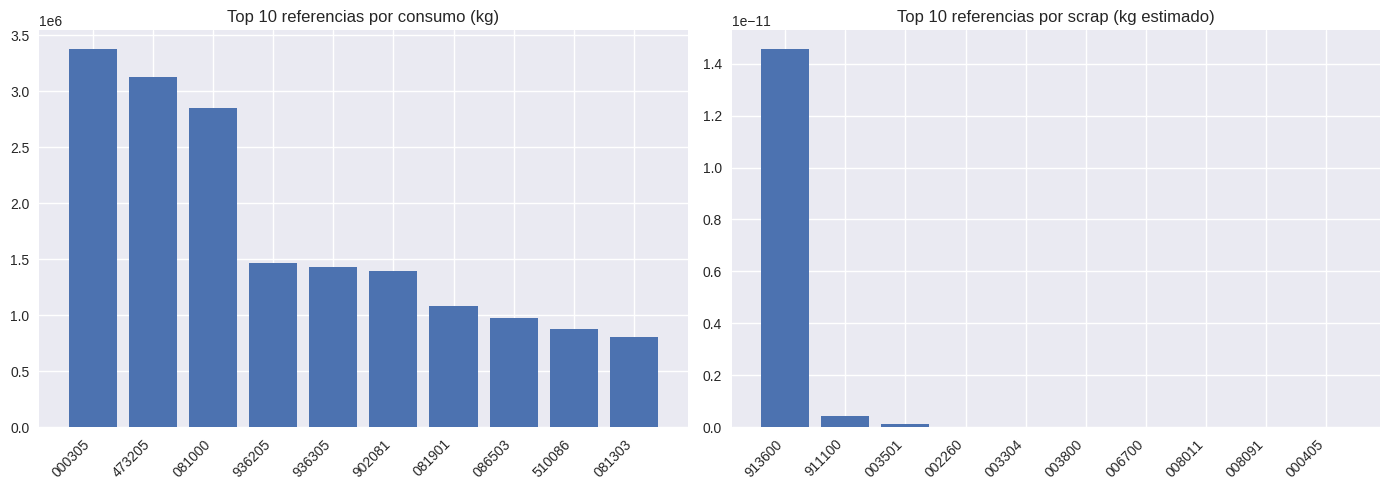

In [162]:

# Top referencias por consumo y scrap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ref_top_consumo = ref_agg.sort_values("consumo_materia_kg_total", ascending=False).head(10)
axes[0].bar(ref_top_consumo["ref_id_str"], ref_top_consumo["consumo_materia_kg_total"])
axes[0].set_title("Top 10 referencias por consumo (kg)")
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].set_xticklabels(ref_top_consumo["ref_id_str"], rotation=45, ha='right')

ref_top_scrap = ref_agg.sort_values("kg_scrap_estimados", ascending=False).head(10)
axes[1].bar(ref_top_scrap["ref_id_str"], ref_top_scrap["kg_scrap_estimados"])
axes[1].set_title("Top 10 referencias por scrap (kg estimado)")
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].set_xticklabels(ref_top_scrap["ref_id_str"], rotation=45, ha='right')

plt.tight_layout()
plt.show()


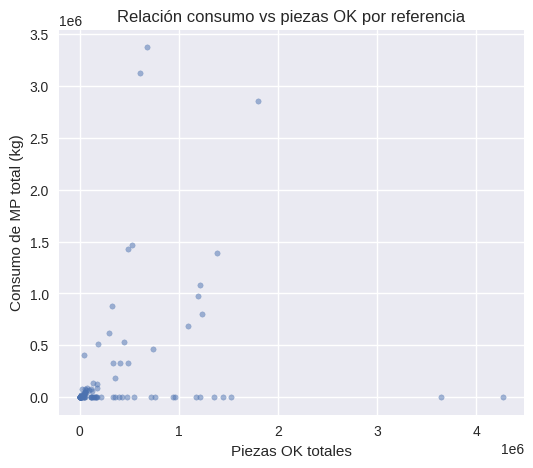

In [163]:
# Dispersión piezas OK vs consumo
plt.figure(figsize=(6, 5))
plt.scatter(ref_agg["piezas_ok_totales"], ref_agg["consumo_materia_kg_total"], alpha=0.5, s=15)
plt.xlabel("Piezas OK totales")
plt.ylabel("Consumo de MP total (kg)")
plt.title("Relación consumo vs piezas OK por referencia")
plt.show()


#### ***Por lote de materia prima***

In [164]:
lot_agg = (
    df.groupby("material_lot_id", dropna=False)
      .agg(
          consumo_materia_kg_total=("consumo_materia_kg","sum"),
          piezas_ok=("piezas_ok","sum"),
          piezas_scrap=("piezas_scrap","sum"),
          scrap_rate_medio=("scrap_rate","mean"),
      )
      .reset_index()
)

lot_agg.sort_values("consumo_materia_kg_total", ascending=False).head(10)


,material_lot_id,consumo_materia_kg_total,piezas_ok,piezas_scrap,scrap_rate_medio
302,NaN,5269826.078,5722232,6149,0.032006
56,LOTE-20250219-0305,765600.000,153120,153,0.031651
234,LOTE-20250618-936205,627278.400,224028,136,0.030500
175,LOTE-20250514-0305473205,528995.000,105799,57,0.034986
89,LOTE-20250312-936305,528552.400,178565,169,0.034854
183,LOTE-20250516-936305,487124.240,164569,165,0.052127
155,LOTE-20250428-081000,430866.150,270985,130,0.003103
162,LOTE-20250430-081901081906,421764.770,473893,480,0.019099
45,LOTE-20250212-081901081906,392111.750,440575,313,0.008439
182,LOTE-20250516-936105,374491.600,133747,183,0.043930


#### ***Capacidad y tiempos***

In [165]:

ref_machine = (
    df.groupby(["ref_id_str","machine_id","machine_name"], dropna=False)
      .agg(
          throughput_uph_medio=("throughput_uph","mean"),
          scrap_rate_medio=("scrap_rate","mean"),
          duracion_min_media=("duracion_min","mean"),
          piezas_ok_por_evento=("piezas_ok","mean"),
      )
      .reset_index()
)

# Añadir lead time si existe la columna
if "lead_time_al_almacen_dias" in df.columns:
    lead = (df.groupby(["ref_id_str","machine_id","machine_name"], dropna=False)
              .agg(lead_time_dias_medio=("lead_time_al_almacen_dias","mean"))
              .reset_index())
    ref_machine = ref_machine.merge(lead, on=["ref_id_str","machine_id","machine_name"], how="left")

ref_machine.sort_values(["throughput_uph_medio"], ascending=False).head(10)


,ref_id_str,machine_id,machine_name,throughput_uph_medio,scrap_rate_medio,duracion_min_media,piezas_ok_por_evento
782,563404,505,SOLDADORA,109840.909091,0.250000,14.500000,993.375000
881,911100,27,Prensa27,58144.827586,0.000000,15.000000,1223.333333
362,081505,542,Soldadora Ideal DD0101,31372.454573,0.000043,108.000000,3021.800000
289,081103,515,SOLDADORA,30344.685936,0.000020,45.800000,1555.450000
558,091503,54,Torno54,24698.259568,0.000000,124.444444,2541.111111
733,500460,25,Curvadora25,22986.024590,0.003070,9.222222,352.555556
704,473205,118,Horno,14820.657644,0.000000,200.125000,2985.075000
839,902081,118,Horno,14542.853020,0.000000,135.000000,3757.833333
382,081730,542,Soldadora Ideal DD0101,13643.539853,0.004183,54.800000,1481.000000
892,913600,542,Soldadora Ideal DD0101,13521.595818,0.000341,83.545455,2023.090909


#### ***Caso de uso simple: baseline para planificar***

In [166]:

# Selección de referencia ejemplo (con peso y throughput disponibles)
ref_candidates = ref_agg.copy()
ref_candidates = ref_candidates[(ref_candidates["ratio_mp_por_1000_ok"].notna()) & (ref_candidates["ratio_mp_por_1000_ok"] > 0)]
ref_candidates = ref_candidates[(ref_candidates["throughput_uph_medio"].notna()) & (ref_candidates["throughput_uph_medio"] > 0)]
ref_candidates = ref_candidates[ref_candidates["peso_positivo"]]

if ref_candidates.empty:
    print("No hay referencias con peso y throughput disponibles para el ejemplo.")
else:
    ref_ejemplo = ref_candidates.sort_values("piezas_ok_totales", ascending=False).iloc[0]["ref_id_str"]
    objetivo_piezas = 5000

    fila = ref_candidates[ref_candidates["ref_id_str"] == ref_ejemplo].iloc[0]
    kg_por_pieza_hist = fila["ratio_mp_por_1000_ok"] / 1000
    kg_mp_estimados = kg_por_pieza_hist * objetivo_piezas

    kg_scrap_por_pieza = fila["kg_scrap_estimados"] / max(fila["piezas_ok_totales"], 1)
    kg_scrap_estimado = kg_scrap_por_pieza * objetivo_piezas

    throughput = fila["throughput_uph_medio"]
    horas_estimadas = objetivo_piezas / throughput if throughput > 0 else np.nan

    print(f"Referencia ejemplo: {ref_ejemplo}")
    print({
        "piezas_objetivo": objetivo_piezas,
        "kg_mp_estimados": kg_mp_estimados,
        "kg_scrap_estimado": kg_scrap_estimado,
        "horas_estimadas": horas_estimadas,
    })


Referencia ejemplo: 081000
{'piezas_objetivo': 5000, 'kg_mp_estimados': np.float64(7950.000000000002), 'kg_scrap_estimado': np.float64(0.0), 'horas_estimadas': np.float64(5.415916651909481)}


#### ***Definición del problema de predicción***

**Unidad de predicción**: evento de operación u orden agregada (work_order_id, ref).

**Inputs (features) sugeridos**
- ref_id_str, familia, peso_neto_kg
- máquina y operación: machine_id, machine_name, op_id, op_text
- contexto temporal: fecha, año_mes, turno implícito
- carga y calidad de MP: material_lot_id, ref_materia_str, qty_recibida, peso_bruto
- señales de eficiencia: throughput_uph, downtime_min, duracion_min, scrap_rate histórico
- variables de planificación: qty_plan, horas_netas

**Outputs (targets)**
- consumo_materia_kg esperado para la orden
- piezas_scrap (o kg_scrap_estimados)
- duracion_min / horas de fabricación
- lead_time_al_almacen_dias

**Métricas de evaluación**
- MAE / RMSE en kg de MP y en horas
- MAPE para scrap_rate y throughput_uph

Este notebook deja los cálculos base y tablas auxiliares listos para usarlos como features o para alimentar un modelo multi-output en el siguiente cuaderno.


In [167]:

# Exportar dataset filtrado para modelos de consumo/tiempo
# Criterios mínimos: ref_id_str presente y peso disponible (>0)
mask_ref = df["ref_id_str"].notna()
mask_peso = df.get("flag_sin_peso")
if mask_peso is not None:
    mask_peso = df.get("flag_sin_peso").fillna(1) == 0
else:
    mask_peso = df.get("peso_neto_kg", 0) > 0

filtro = mask_ref & mask_peso
filtered = df[filtro].copy()

print({
    "filas_totales": len(df),
    "filas_filtradas": len(filtered),
    "refs_distintas": df["ref_id_str"].nunique(),
    "refs_filtradas": filtered["ref_id_str"].nunique(),
})

OUTPUT_FILTERED = "../../data/proccessed/consumo_filtrado.csv"
filtered.to_csv(OUTPUT_FILTERED, index=False)
print("Guardado filtrado en:", OUTPUT_FILTERED)
filtered.head(3)


{'filas_totales': 64555, 'filas_filtradas': 30948, 'refs_distintas': 92, 'refs_filtradas': 48}
Guardado filtrado en: ../../data/proccessed/consumo_filtrado.csv


,work_order_id,op_id,machine_id,machine_name,planta,op_text,ref_id_str,familia,peso_neto_kg,material_lot_id,ref_materia_str,ts_ini,ts_fin,fecha,duracion_min,evento,tipo_incidencia,piezas_ok,piezas_scrap,qty_plan,qty_estimado,qty_in_almacen_dia,año_mes,horas_teoricas,reduccion_tco,horas_ajustadas,horas_enfermedad,horas_accidente,horas_permiso,horas_netas,qty_recibida,peso_bruto,uds,fecha_recepcion_ts,throughput_uph,scrap_rate,downtime_min,consumo_materia_kg,flag_sin_peso,flag_con_peso
0,24/0767,TALLADO,49,Talladora49,Abadiño,TALLADO,000305,CORONA DE ARRANQUE,5.0,NaN,NaN,2025-01-28 00:50:00,2025-01-28 01:39:00,2025-01-28,49.0,Preparación,NaN,0,0,0.0,592.0,NaN,2025-01,12350.0,788.0,11562.0,752.0,0.0,390.0,10420.0,NaN,NaN,NaN,NaT,0.000000,NaN,0.0,0.0,0,1
1,24/0767,TALLADO,49,Talladora49,Abadiño,TALLADO,000305,CORONA DE ARRANQUE,5.0,NaN,NaN,2025-01-28 05:17:00,2025-01-28 05:49:00,2025-01-28,32.0,Incidencia,AUSENCIA,0,0,0.0,592.0,NaN,2025-01,12350.0,788.0,11562.0,752.0,0.0,390.0,10420.0,NaN,NaN,NaN,NaT,0.000000,NaN,32.0,0.0,0,1
2,24/0767,TALLADO,49,Talladora49,Abadiño,TALLADO,000305,CORONA DE ARRANQUE,5.0,NaN,NaN,2025-01-28 01:39:00,2025-01-28 06:29:00,2025-01-28,290.0,Producción,NaN,105,3,0.0,592.0,NaN,2025-01,12350.0,788.0,11562.0,752.0,0.0,390.0,10420.0,NaN,NaN,NaN,NaT,21.724138,0.027778,0.0,525.0,0,1
